In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

# import classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# import metrics to be used
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as ACC
from sklearn.metrics import precision_score as PREC
from sklearn.metrics import recall_score as REC
from sklearn.metrics import roc_auc_score as ROC
from sklearn.metrics import f1_score as F1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
features = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income"
]

categories = { 
    "workclass": "category",
    "education": "category",
    "marital-status": "category",
    "occupation": "category",
    "relationship": "category",
    "race": "category",
    "sex": "category",
    "native-country": "category",
    "income": "category"
}

classifiers = [
    ("kneighbors", KNeighborsClassifier()),
    ("naive_bayes", GaussianNB()),
    ("linear_svc", LinearSVC(random_state = 309)),
    ("decision_tree", DecisionTreeClassifier(random_state = 309)),
    ("random_forest", RandomForestClassifier(random_state = 309)),
    ("ada_boost", AdaBoostClassifier(random_state = 309)),
    ("gradient_boosting", GradientBoostingClassifier(random_state = 309)),
    ("lda", LinearDiscriminantAnalysis()),
    ("mlp", MLPClassifier(random_state = 309)),
    ("log_regression", LogisticRegression(random_state = 309)),
]

# Scoring callables to score each regressor
metrics = {
    "acc": make_scorer(lambda y_true, y_pred: ACC(y_true, y_pred)),
    "prec": make_scorer(lambda y_true, y_pred: PREC(y_true, y_pred)),
    "rec": make_scorer(lambda y_true, y_pred: REC(y_true, y_pred)),
    "f1": make_scorer(lambda y_true, y_pred: REC(y_true, y_pred)),
    "roc_auc": make_scorer(lambda y_true, y_pred: ROC(y_true, y_pred)),
}

In [3]:
# load data
training_data = pd.read_csv("data/adult.data", sep = ",", names = features, dtype = categories)
testing_data = pd.read_csv("data/adult.test", sep = ",", skiprows = 1, names = features, dtype = categories)
training_data = pd.DataFrame(training_data, columns = features)
testing_data = pd.DataFrame(testing_data, columns = features)

In [4]:
# dealing with missing values
training_data.replace(to_replace = " ?", value = np.nan, inplace = True)
testing_data.replace(to_replace = " ?", value = np.nan, inplace = True)

# dropping non-useful columns
training_data.drop(["fnlwgt"], axis = 1, inplace = True)
testing_data.drop(["fnlwgt"], axis = 1, inplace = True)

train_cat = training_data.select_dtypes(include = 'category')
test_cat = testing_data.select_dtypes(include = 'category')

train_num = training_data.select_dtypes(include = 'number')
test_num = testing_data.select_dtypes(include = 'number')

# separate target variable
train_cat.drop(columns = "income", inplace = True)
test_cat.drop(columns = "income", inplace = True)

In [5]:
num_feats = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

# drop duplicate feature
train_cat.drop(columns = ["education"], inplace = True)
test_cat.drop(columns = ["education"], inplace = True)

# replace missing values with the most common
fill_mode = {"workclass": " Private", "occupation": " Prof-specialty", "native-country": " United-States"}
train_cat.fillna(value = fill_mode, inplace = True)
test_cat.fillna(value = fill_mode, inplace = True)

# ohe categorical features
train_cat = pd.get_dummies(train_cat)
test_cat = pd.get_dummies(test_cat)

# scale numerical features
scaler1 = StandardScaler()
scaler2 = StandardScaler()
train_num = pd.DataFrame(scaler1.fit_transform(train_num), columns = num_feats)
test_num = pd.DataFrame(scaler2.fit_transform(test_num), columns = num_feats)

X_train = pd.concat([train_num, train_cat], axis = 1, join = 'inner')
X_test = pd.concat([test_num, test_cat], axis = 1, join = 'inner')
df_X = pd.concat([X_train, X_test], ignore_index = True)

df_X.fillna(value = 0, inplace = True)

y_test = testing_data.iloc[:, -1]
y_train = training_data.iloc[:, -1]

# dealing with inconsistent class labels between training and test and make binaray classification
y_test = y_test.replace(" <=50K.", value = 0)
y_test = y_test.replace(" >50K.", value = 1)
y_train = y_train.replace(" <=50K", value = 0)
y_train = y_train.replace(" >50K", value = 1)

df_y = pd.concat([y_train, y_test], ignore_index = True)
df_full = pd.concat([df_X, df_y], axis = 1, join = "inner")

In [6]:
# Setting up for classification

X = df_full.iloc[:, :-1]
y = df_full.iloc[:, -1]
train_indices = np.array(range(32561))
test_indices = np.array(range(32561, 48842))

# Split for testing
tt_split = [(train_indices, test_indices)]

X_train = X.iloc[:32561, :]
y_train = y.iloc[:32561]
X_test = X.iloc[32561:, :]
y_test = y.iloc[32561:]

In [7]:
# Collecting results

cms = []
results = []


for i in range(len(classifiers)):
    clf_name = classifiers[i][0]
    clf = classifiers[i][1]
    print((clf_name, clf))
    scores = cross_validate(clf, X, y, scoring = metrics, cv =tt_split)
    results.append(scores)

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels = clf.classes_)
    cms.append(ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_))

('kneighbors', KNeighborsClassifier())
('naive_bayes', GaussianNB())
('linear_svc', LinearSVC(random_state=309))


C:\Users\joshu\AppData\Local\Programs\Orange\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\joshu\AppData\Local\Programs\Orange\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


('decision_tree', DecisionTreeClassifier(random_state=309))
('random_forest', RandomForestClassifier(random_state=309))
('ada_boost', AdaBoostClassifier(random_state=309))
('gradient_boosting', GradientBoostingClassifier(random_state=309))
('lda', LinearDiscriminantAnalysis())
('mlp', MLPClassifier(random_state=309))


C:\Users\joshu\AppData\Local\Programs\Orange\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\joshu\AppData\Local\Programs\Orange\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


('log_regression', LogisticRegression(random_state=309))


C:\Users\joshu\AppData\Local\Programs\Orange\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\joshu\AppData\Local\Programs\Orange\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

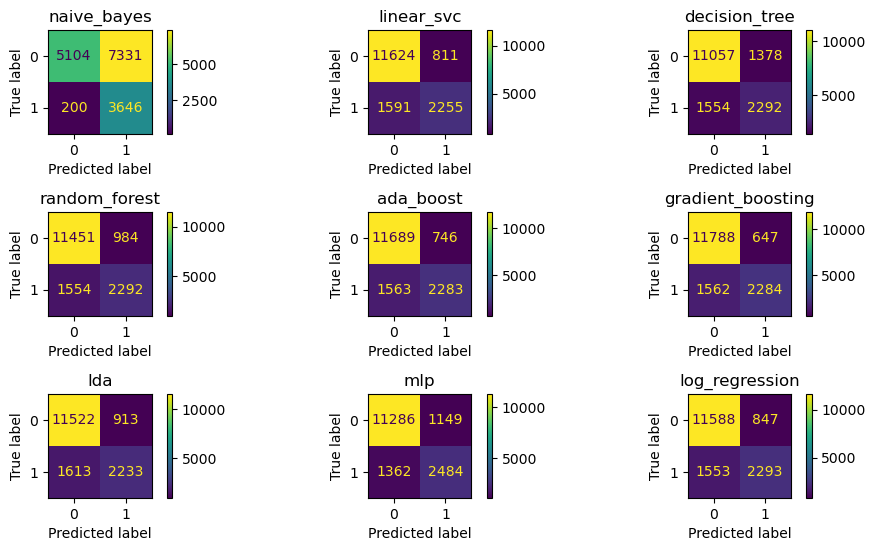

In [8]:
# plotting confusion matrices

fig = plt.figure(figsize=(10,7))
columns = 3
rows = 4
for i in range(1, 10):
    ax = fig.add_subplot(rows, columns, i)
    cms[i].plot(ax = ax)
    ax.set_title(classifiers[i][0])
plt.tight_layout()
plt.show()

In [9]:
# showing results of metrics
def get_underlying_result(d):
    for k,v in zip(d.keys(), d.values()):
        d[k] = d[k].item()

for d in results:
    get_underlying_result(d)

In [10]:
clf_names = np.array(classifiers, dtype = object)[:, 0]
eval_mets = results[0].keys()
results_df = pd.DataFrame(results, index = clf_names, columns = eval_mets)
sorted_results = results_df.sort_values("test_acc", ascending = False)
sorted_results.round(2)

,fit_time,score_time,test_acc,test_prec,test_rec,test_f1,test_roc_auc
gradient_boosting,4.66,0.06,0.86,0.78,0.59,0.59,0.77
ada_boost,1.88,0.28,0.86,0.75,0.59,0.59,0.77
log_regression,0.52,0.04,0.85,0.73,0.60,0.60,0.76
linear_svc,2.08,0.03,0.85,0.74,0.59,0.59,0.76
mlp,46.02,0.03,0.85,0.68,0.65,0.65,0.78
lda,0.41,0.02,0.84,0.71,0.58,0.58,0.75
random_forest,3.49,0.39,0.84,0.70,0.60,0.60,0.76
kneighbors,0.03,1.53,0.83,0.67,0.60,0.60,0.75
decision_tree,0.28,0.03,0.82,0.62,0.60,0.60,0.74
naive_bayes,0.07,0.06,0.54,0.33,0.95,0.95,0.68
